# Feature comparison for ST-GCN and CoST-GCN prior to average pooling layer
This serves as an exploratory analysis to determine if a clear difference can be found

In [97]:
import torch
import numpy as np
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

import seaborn as sns
sns.set_theme();

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

In [39]:
def load_features(path):
    with open(path, "rb") as f:
        res = np.load(f)
    return res


def joyplot(data2d, colormap="viridis", opacity=0.6, y_scale=1.0, title="Joy Plot"):
    # Prepare data
    y_skip=1.0
    C = data2d.shape[1]
    hist_data = [data2d[:,i] for i in range(C)]
    group_labels = [str(i) for i in range(C)]
    
    colormap = cm.get_cmap(colormap, C)
    if type(colormap) == LinearSegmentedColormap:
        colormap = cm.get_cmap(colormap, C+1)
        colors = [f"rgba({', '.join([str(i) for i in colormap(i)[:3]])}, {opacity})" for i in range(1,C+1)]
        colors = colors[::-1]
    else:
        colors = [f"rgba({', '.join([str(i) for i in c[:3]])}, {opacity})" for c in colormap.colors]

    fig = go.Figure()
    for i, (h, l, c) in enumerate(zip(hist_data, group_labels, colors)):
        base = y_skip*(C-i-1)

        s = ff.create_distplot([h], [l], show_hist=False, show_rug=False, colors=[c], bin_size=0.19)._data_objs[0]
        s.y *= y_scale
        s.y += base
        s.marker.color = "white"
        fig.add_trace(s)

        s.marker.color = c
        s.fillcolor = c
        s.y = base * np.ones_like(s.y)
        s.fill='tonexty'
        fig.add_trace(s)


    fig.update_layout(
        title=title,
        showlegend=False,
        yaxis=dict(showticklabels=True, tickvals=list(range(C))), #dtick=y_skip, tick0=C),
        height=40*C,
    )
    return fig


def stats(x):
    return dict(min=x.min(), mean=x.mean(), median=np.median(x), std=np.std(x), max=x.max())

def avg_pool(x):
    N, C, T, S = x.shape
    M = 2
    return x.reshape(N//M, M, C, -1).mean(3).mean(1)

def pair_box_plot(a, b, a_name="st_gcn", b_name="cost_gcn"):
    assert a.shape == b.shape
    C, M = a.shape
    dfa = pd.DataFrame(data=a.flatten(), columns=["value"])
    dfa["channel"] = np.tile(np.arange(C), M)
    dfa["model"] = a_name

    dfb = pd.DataFrame(data=b.flatten(), columns=["value"])
    dfb["channel"] = np.tile(np.arange(C), M)
    dfb["model"] = b_name

    df = dfa.merge(dfb, how="outer")

    # Box plot
    fig = px.box(df, x="channel", y="value", color="model", points=False)
    fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
    return fig

def pair_violin_plot(a, b, a_name="st_gcn", b_name="cost_gcn"):
    assert a.shape == b.shape
    C, M = a.shape
    dfa = pd.DataFrame(data=a.flatten(), columns=["value"])
    dfa["channel"] = np.tile(np.arange(C), M)
    dfa["model"] = a_name

    dfb = pd.DataFrame(data=b.flatten(), columns=["value"])
    dfb["channel"] = np.tile(np.arange(C), M)
    dfb["model"] = b_name

    df = dfa.merge(dfb, how="outer")

    # Box plot
    fig = px.violin(df, x="channel", y="value", color="model", points=False, box=True)
#     fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
    return fig

## ST-GCN

In [163]:
feat_st_gcn = load_features("/mnt/archive/common/projects/cost_gcn/logs/run_logs/feature_extraction/version_4/features/test/layers_layer10.npy")
feat_st_gcn.shape

In [7]:
# Pooling
feat_st_gcn_mean = avg_pool(feat_st_gcn)
feat_st_gcn_mean.shape

(1280, 256)

In [8]:
# Reduced size
M = 200
C = 20
feat_st_gcn_mini_mean = feat_st_gcn_mean[:M, :C]
feat_st_gcn_mini_mean.shape

(200, 20)

In [58]:
avg_pool(feat_st_gcn[:,:,delay:length-delay]).shape

(1280, 256)

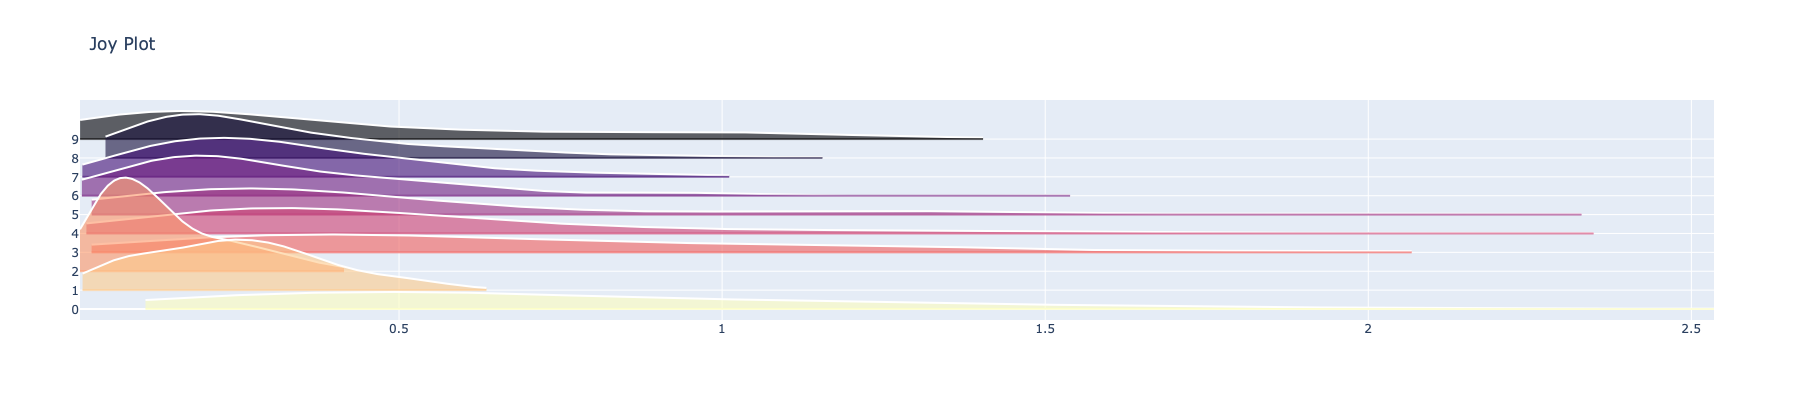

In [176]:
cmap = "magma" # 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
delay = 19

# Start
fig = joyplot(avg_pool(feat_st_gcn[:,:,:delay])[:,:10], cmap, y_scale=1)
fig.show()

In [ ]:
# Middle
fig = joyplot(avg_pool(feat_st_gcn[:,:,delay:-delay])[:,:10], cmap, y_scale=1)
fig.show()

In [ ]:
# End
fig = joyplot(avg_pool(feat_st_gcn[:,:,-delay:])[:,:10], cmap, y_scale=1)
fig.show()

## CoST-GCN

In [164]:
feat_cost_gcn = load_features("/mnt/archive/common/projects/cost_gcn/logs/run_logs/feature_extraction/version_5/features/test/layers_layer10.npy")
feat_cost_gcn.shape

(19200, 256, 25)

In [167]:
feat_cost_gcn = feat_cost_gcn.reshape(256, 256, 75, 25)
feat_cost_gcn.shape

(2560, 256, 75, 25)

In [169]:
feat_st_gcn[0,:,delay+1] - feat_cost_gcn[0,:,2*delay+1]

array([[ 0.        ,  0.        ,  0.07768214, ...,  1.0030912 ,
         0.2646941 ,  0.        ],
       [ 0.        ,  0.78252184,  0.44514087, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30045348, -0.45079428, -0.17102873, ...,  0.        ,
         1.239226  ,  0.8927118 ],
       ...,
       [ 0.        ,  0.02920252,  0.        , ..., -0.99986607,
        -1.2465808 ,  0.34135103],
       [ 0.        ,  0.        ,  0.30849496, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         4.197898  ,  7.1684656 ]], dtype=float32)

In [17]:
# Pooling
feat_cost_gcn_mean = avg_pool(feat_cost_gcn)
feat_cost_gcn_mean.shape

(1280, 256)

In [18]:
# Reduced size
M = 200
C = 20
feat_cost_gcn_mini_mean = feat_cost_gcn_mean[:M, :C] # Across joints 
feat_cost_gcn_mini_mean.shape

(200, 20)

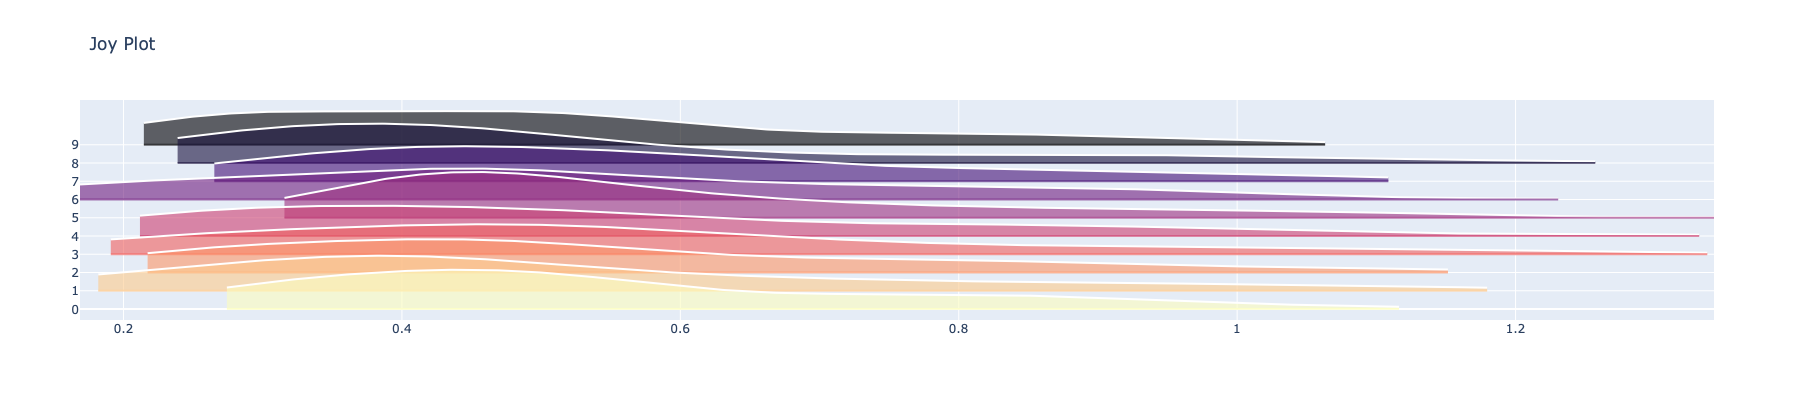

In [170]:
fig = joyplot(avg_pool(feat_cost_gcn[:,:,-2*delay:])[:,:10], "magma", y_scale=1)
fig.show()

## Compare descriptive statistics

### ST-GCN

In [197]:
# Total
stats(feat_st_gcn_mean)

{'min': 7.040943e-05,
 'mean': 0.45356497,
 'median': 0.34305543,
 'std': 0.3874999,
 'max': 4.485907}

In [198]:
# Start region (padded)
stats(avg_pool(feat_st_gcn[:,:,:10]))

{'min': 0.0,
 'mean': 0.42913628,
 'median': 0.30672526,
 'std': 0.40700802,
 'max': 6.3562593}

In [199]:
# Middle region (not padded)
stats(avg_pool(feat_st_gcn[:,:,10:65]))

{'min': 0.0,
 'mean': 0.47826496,
 'median': 0.35951236,
 'std': 0.41588253,
 'max': 5.501658}

In [200]:
# End region (padded)
stats(avg_pool(feat_st_gcn[:,:,65:]))

{'min': 0.0,
 'mean': 0.34214386,
 'median': 0.24545984,
 'std': 0.32278264,
 'max': 4.5891376}

### CoST-GCN

In [201]:
# Total
stats(feat_cost_gcn_mean)

{'min': 0.0,
 'mean': 0.5298247,
 'median': 0.4666525,
 'std': 0.43415722,
 'max': 6.3048863}

In [202]:
# Start region (padded)
stats(avg_pool(feat_cost_gcn[:,:,:10]))

{'min': 0.0,
 'mean': 0.5297647,
 'median': 0.4457327,
 'std': 0.44941473,
 'max': 6.874723}

In [203]:
# Middle region (not padded)
stats(avg_pool(feat_cost_gcn[:,:,10:65]))

{'min': 0.0,
 'mean': 0.5296774,
 'median': 0.46494347,
 'std': 0.43480465,
 'max': 6.3010845}

In [204]:
# End region (padded)
stats(avg_pool(feat_cost_gcn[:,:,65:]))

{'min': 0.0,
 'mean': 0.5306963,
 'median': 0.4460249,
 'std': 0.4499213,
 'max': 7.017437}

## Box plot

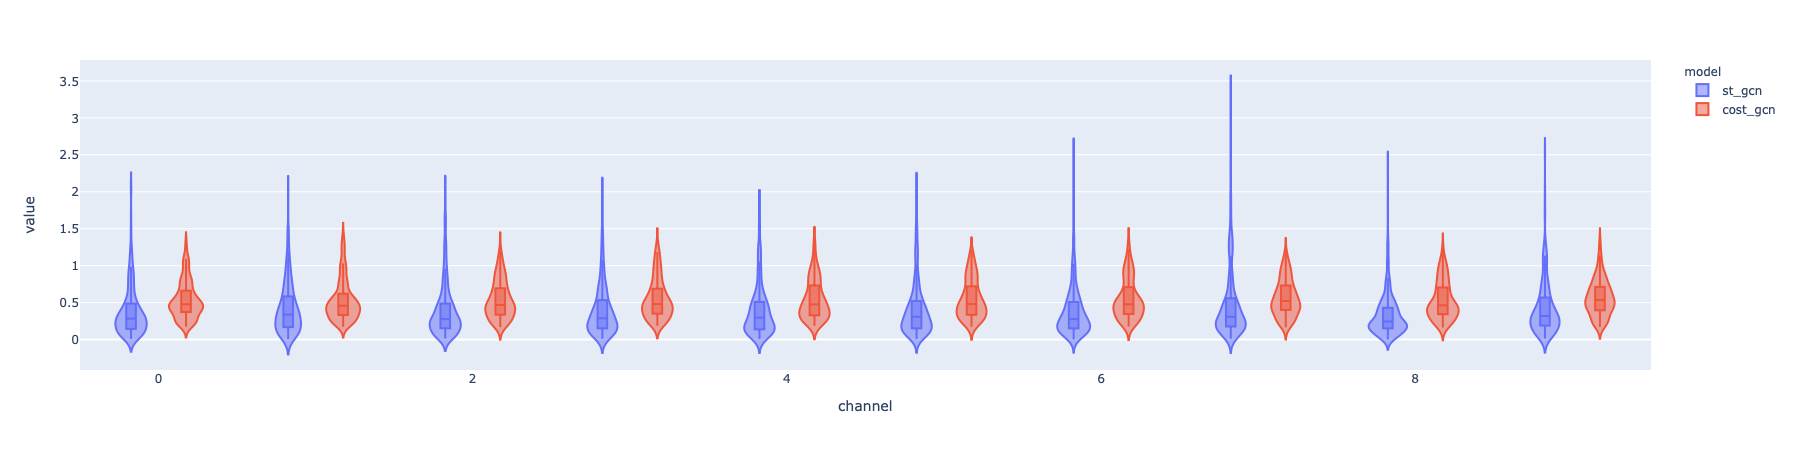

In [153]:
# Middle
M = 300
C = 10
delay = 19
length = 75
fig = pair_violin_plot(
    avg_pool(feat_st_gcn[:,:,delay:length-delay])[:M,:C].T, 
    avg_pool(feat_cost_gcn[:,:,length-2*delay:])[:M,:C].T
)
fig.show()

In [158]:
batches = 3
M = 2
C = 26
T = 75
V = 25
BS = 18

feat = np.arange(batches * M * C * T * V * BS).reshape(batches*BS*M, C, T, V)

st_feat = []
for b in range(batches):
    for x in range(BS*M):
        st_feat.append(feat[b*BS*M+x])


cost_feat = []
for b in range(batches):
    for t in range(T):
        for x in range(BS*M):
            cost_feat.append(feat[b*BS*M+x,:,t])
            
st_feat = np.stack(st_feat)
cost_feat = np.stack(cost_feat)

In [159]:
st_feat.shape

(108, 26, 75, 25)

In [160]:
cost_feat.shape

(8100, 26, 25)

In [156]:
cost_feat2 = 

In [174]:
np.sum(st_feat - cost_feat.reshape(batches*BS*M, C, T, V))

0